
# Optimización No Lineal (NLP): Tutorial práctico y guiado

**Curso:** Modelado en Optimización  
**Autor:** Camilo Gómez (con apoyo de ChatGPT)  
**Objetivo:** Entender, formular y resolver problemas de **optimización no lineal** (convexos y no convexos), conectando intuición, deducción de ecuaciones y métodos de solución prácticos.

---

## Contenido
1. [Motivación y panorama](#1)
2. [Formulación general de NLP](#2)
3. [Convexidad y consecuencias](#3)
4. [Condiciones KKT y dualidad](#4)
5. [Métodos de solución y cuándo usarlos](#5)
6. [Ejemplo A: Portafolio media–varianza (convexo, con simplex)](#6)
7. [Ejemplo B: Regresión logística (convexo)](#7)
8. [Ejemplo C: Ajuste no lineal de parámetros físicos (no lineal, LS)](#8)
9. [Ejemplo D: Problema no convexo en 2D y trayectorias](#9)
10. [Checklist de modelado y elección de métodos](#10)
11. [Referencias y recursos](#11)

> En cada ejemplo, conectamos **formulación** → **intuición** → **solución** → **diagnóstico**.



<a id="1"></a>
## 1. Motivación y panorama

Muchos problemas reales requieren **objetivos y/o restricciones no lineales**:

- **Finanzas:** equilibrio entre retorno y riesgo (varianza) → función **cuadrática**.
- **Energía / Control / Física:** energías potenciales o funciones de potencia no lineal.
- **Aprendizaje de máquina:** pérdidas convexas (logística) y no convexas (redes neuronales).
- **Ingeniería / Economía:** costos, rendimientos decrecientes, utilidades, penalizaciones.

La **no linealidad** cambia el juego: los métodos de programación lineal dejan de aplicar directamente. Necesitamos otras herramientas para garantizar (o no) optimalidad y, sobre todo, **procedimientos numéricos robustos**.



<a id="2"></a>
## 2. Formulación general de NLP

La forma estándar de un problema de optimización no lineal es:
\[
\begin{aligned}
\min_{x\in\mathbb{R}^n} \quad & f(x) \\
\text{s.a.}\quad & g_i(x) \le 0,\quad i=1,\dots,m,\\
& h_j(x) = 0,\quad j=1,\dots,p.
\end{aligned}
\]

- \(f\): objetivo (no lineal, puede ser convexo o no).
- \(g_i\): restricciones de desigualdad.
- \(h_j\): restricciones de igualdad.

**Casos frecuentes**
- **Sin restricciones**: \( \min_x f(x) \).
- **Caja**: \( l \le x \le u \) (bound-constrained, útil para L-BFGS-B).
- **Simplex**: \( x \ge 0,\ \mathbf{1}^\top x = 1 \).
- **QCQP / SOCP**: restricciones cuadráticas / cónicas (aún convexas si matrices son PSD).



<a id="3"></a>
## 3. Convexidad y consecuencias

- Un conjunto \( \mathcal{X} \) es **convexo** si para \( x,y\in\mathcal{X} \) y \( \theta\in[0,1] \), \( \theta x + (1-\theta)y\in\mathcal{X} \).
- Una función \( f \) es **convexa** si para todo \( x,y \) y \( \theta\in[0,1] \):  
  \[ f(\theta x+(1-\theta)y)\le \theta f(x) + (1-\theta) f(y). \]

**Consecuencias clave:**
- En **problemas convexos**, **todo mínimo local es global**.
- En **no convexos**, puede haber múltiples mínimos locales: el inicial y el método importan.

**Diagnóstico práctico**
- Si \( \nabla^2 f(x)\succeq 0 \) (matriz Hessiana PSD) para todo \( x \): \( f \) es convexa.
- Si la región factible es intersección de conjuntos convexos, el problema es convexo (asumiendo \( f \) convexa).



<a id="4"></a>
## 4. Condiciones KKT y dualidad (intuición)

Para un problema suave con desigualdades \(g_i\) y igualdades \(h_j\), bajo condiciones regulares (CQ), **en un óptimo** \(x^\star\) existen multiplicadores \(\lambda_i\ge 0\) y \(\nu_j\) tales que:

1. **Estacionariedad:**  
   \[ \nabla f(x^\star) + \sum_{i=1}^m \lambda_i \nabla g_i(x^\star) + \sum_{j=1}^p \nu_j \nabla h_j(x^\star) = 0. \]
2. **Factibilidad primal:** \(g_i(x^\star)\le 0,\ h_j(x^\star)=0.\)
3. **Complementariedad:** \(\lambda_i\, g_i(x^\star) = 0,\ \lambda_i\ge 0.\)
4. **(Opcional) Factibilidad dual y segundas condiciones:** garantizan mínimo y no máximo/silla.

- En **convexos** (f convexa, restricciones convexas/afines), KKT son **condiciones necesarias y suficientes**.
- En **no convexos**, KKT son necesarias (bajo CQ), pero **no garantizan globalidad**.



<a id="5"></a>
## 5. Métodos de solución y cuándo usarlos

**Sin restricciones / caja (bounds):**
- **Descenso por gradiente** / **L-BFGS-B** (rápidos, requieren gradiente; L-BFGS-B maneja límites).
- **Newton / trust-region** (usan Hessiano o aproximaciones).

**Con restricciones generales:**
- **Gradiente proyectado** (simplex o cajas).
- **SQP (Sequential Quadratic Programming)**: resuelve QP sucesivos; muy usado.
- **Punto interior**: robusto en convexos (QP/QCQP/SOCP) y disponible en solvers generales.
- **`scipy.optimize.minimize`** con métodos: `"L-BFGS-B"`, `"SLSQP"`, `"trust-constr"`.

**Regla práctica:**
- Convexo + suave → cualquiera de los anteriores suele converger bien.
- No convexo → probar múltiples inicializaciones, métodos trust-region, o variantes aleatorias.
- Restricciones de igualdad lineales → reducir dimensión (parametrizar) o usar SLSQP/trust-constr.


In [1]:

# Utilidades comunes
import numpy as np
import math
from dataclasses import dataclass
from typing import Callable, Tuple, Dict, Any

import matplotlib.pyplot as plt  # Reglas del curso: no seaborn, un gráfico por celda, sin fijar colores
from scipy.optimize import minimize
np.set_printoptions(precision=4, suppress=True)



### 5.1 Proyección al simplex y Gradiente Proyectado (para restricciones tipo \(x\ge 0, \mathbf{1}^\top x = 1\))

- **Proyección al simplex**: operador \( \Pi_\Delta(y) = \arg\min_{x\in\Delta} \|x-y\|_2 \) con \( \Delta=\{x\ge 0,\ \mathbf{1}^\top x = 1\} \).
- **Gradiente proyectado**: \( x^{k+1} = \Pi_\Delta(x^k - \alpha_k \nabla f(x^k)) \).


In [2]:

def project_to_simplex(y: np.ndarray) -> np.ndarray:
    """Proyecta y al simplex {x >= 0, sum x = 1} usando el algoritmo de sorting-threshold."""
    y = np.asarray(y, dtype=float)
    u = np.sort(y)[::-1]
    cssv = np.cumsum(u)
    rho = np.where(u > (cssv - 1) / (np.arange(len(y)) + 1))[0][-1]
    theta = (cssv[rho] - 1) / (rho + 1)
    x = np.maximum(y - theta, 0.0)
    return x

def projected_gradient(f: Callable[[np.ndarray], float],
                       grad: Callable[[np.ndarray], np.ndarray],
                       x0: np.ndarray,
                       step: float = 1e-1,
                       max_iter: int = 1000,
                       tol: float = 1e-6,
                       projector: Callable[[np.ndarray], np.ndarray] = project_to_simplex,
                       record_path: bool = True):
    """Gradiente proyectado genérico sobre un conjunto con proyector dado."""
    x = projector(x0)
    path = [x.copy()] if record_path else None
    for k in range(max_iter):
        g = grad(x)
        x_new = projector(x - step * g)
        if np.linalg.norm(x_new - x) < tol:
            x = x_new
            if record_path: path.append(x.copy())
            break
        x = x_new
        if record_path: path.append(x.copy())
    return (x, k+1, path) if record_path else (x, k+1, None)



<a id="6"></a>
## 6. Ejemplo A — Portafolio media–varianza (convexo, con simplex)

**Formulación:**
\[
\begin{aligned}
\min_{x} \quad & x^\top \Sigma x - \lambda\, \mu^\top x \\
\text{s.a.} \quad & \mathbf{1}^\top x = 1, \quad x \ge 0.
\end{aligned}
\]

- \(x\): pesos del portafolio.  
- \(\mu\): retornos esperados.  
- \(\Sigma\): matriz de covarianzas (PSD).  
- \(\lambda > 0\): aversión al riesgo.

**Convexidad**: \(x^\top \Sigma x\) convexo si \(\Sigma\succeq 0\); \(-\lambda \mu^\top x\) es lineal. Restricciones forman el **simplex**.


In [3]:

# Datos sintéticos
np.random.seed(0)
n = 6
mu = np.random.uniform(0.02, 0.15, size=n)
A = np.random.randn(n, n)
Sigma = A @ A.T / n + 0.05*np.eye(n)  # PSD + ruido diagonal

lam = 5.0

def f_port(x):
    return float(x @ (Sigma @ x) - lam * (mu @ x))

def g_port(x):
    return 2 * (Sigma @ x) - lam * mu

# Resolver por gradiente proyectado (simplex)
x0 = np.ones(n)/n
x_pg, iters, path = projected_gradient(f_port, g_port, x0, step=0.1, max_iter=2000, tol=1e-8)

print("Gradiente proyectado — iteraciones:", iters)
print("x*:", x_pg.round(4))
print("suma(x*):", x_pg.sum().round(4), "  min/max:", x_pg.min().round(4), x_pg.max().round(4))
print("riesgo:", float(x_pg @ (Sigma @ x_pg)), "  retorno:", float(mu @ x_pg), "  f:", f_port(x_pg))


Gradiente proyectado — iteraciones: 167
x*: [0.2436 0.3546 0.0617 0.     0.1612 0.1789]
suma(x*): 1.0   min/max: 0.0 0.3546
riesgo: 0.1538487330213149   retorno: 0.09908342761443668   f: -0.3415684050508685


In [4]:

# Resolver con scipy.optimize (SLSQP / trust-constr)
cons = (
    {"type": "eq", "fun": lambda x: np.sum(x) - 1.0},  # simplex
)
bounds = [(0.0, 1.0) for _ in range(n)]

res_slsqp = minimize(f_port, x0, jac=g_port, method="SLSQP", constraints=cons, bounds=bounds)
res_trust = minimize(f_port, x0, jac=g_port, method="trust-constr", constraints=cons, bounds=bounds)

print("SLSQP status:", res_slsqp.message)
print("x*(SLSQP):", res_slsqp.x.round(4), " f:", res_slsqp.fun)
print("trust-constr status:", res_trust.message)
print("x*(trust):", res_trust.x.round(4), " f:", res_trust.fun)


SLSQP status: Optimization terminated successfully
x*(SLSQP): [0.2438 0.3547 0.0618 0.     0.1611 0.1786]  f: -0.3415681296613541
trust-constr status: `gtol` termination condition is satisfied.
x*(trust): [0.2436 0.3546 0.0617 0.     0.1612 0.1789]  f: -0.34156839481080065


C:\Users\ch.gomez171\AppData\Local\Anaconda3new\Lib\site-packages\scipy\optimize\_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '



<a id="7"></a>
## 7. Ejemplo B — Regresión logística (convexo)

**Formulación (regularizada):**
\[
\min_{w,b}\ \frac{1}{N}\sum_{i=1}^N \log\!\big(1+\exp(-y_i(w^\top x_i + b))\big) + \frac{\lambda}{2}\|w\|_2^2.
\]

- **Convexo** en \( (w,b) \).  
- Sin restricciones (bounds opcionales).  
- Se resuelve con **L-BFGS-B** o **trust-region** fácilmente.


Convergencia: CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL
theta*: [ 1.3126  1.3721 -0.0463]   loss: 0.026882925967987067


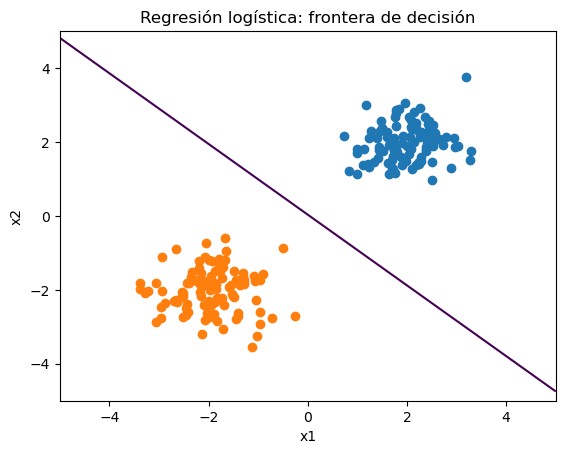

In [5]:

# Datos sintéticos separables
rng = np.random.default_rng(42)
N = 200
X_pos = rng.normal([2,2], 0.6, size=(N//2, 2))
X_neg = rng.normal([-2,-2], 0.6, size=(N//2, 2))
X = np.vstack([X_pos, X_neg])
y = np.hstack([np.ones(N//2), -np.ones(N//2)])  # en {-1, +1}

def sigmoid(z):
    return 1.0 / (1.0 + np.exp(-z))

def logistic_loss(theta):
    w = theta[:-1]
    b = theta[-1]
    z = X @ w + b
    return np.mean(np.log(1 + np.exp(-y * z))) + 0.5*1e-2*np.dot(w,w)

def logistic_grad(theta):
    w = theta[:-1]
    b = theta[-1]
    z = X @ w + b
    s = sigmoid(-y*z)
    grad_w = np.mean((-y[:,None] * X) * s[:,None], axis=0) + 1e-2*w
    grad_b = np.mean(-y * s)
    return np.hstack([grad_w, grad_b])

theta0 = np.zeros(3)  # [w1, w2, b]
res = minimize(logistic_loss, theta0, jac=logistic_grad, method="L-BFGS-B")
theta_star = res.x
print("Convergencia:", res.message)
print("theta*:", theta_star.round(4), "  loss:", res.fun)

# Visualización simple de frontera
xx, yy = np.meshgrid(np.linspace(-5,5,200), np.linspace(-5,5,200))
zz = theta_star[0]*xx + theta_star[1]*yy + theta_star[2]

plt.figure()
plt.scatter(X_pos[:,0], X_pos[:,1])
plt.scatter(X_neg[:,0], X_neg[:,1])
plt.contour(xx, yy, zz.reshape(xx.shape), levels=[0])
plt.title("Regresión logística: frontera de decisión")
plt.xlabel("x1"); plt.ylabel("x2")
plt.show()



<a id="8"></a>
## 8. Ejemplo C — Ajuste no lineal de parámetros físicos (LS no lineal)

Suponga un sistema con respuesta \( y(t; a,b) = a\,(1 - e^{-b t}) + \epsilon \). Queremos estimar \( (a,b) \) por **mínimos cuadrados no lineales**:

\[
\min_{a,b} \ \sum_{i} \big( y_i - a(1 - e^{-b t_i}) \big)^2.
\]

- **No lineal** en parámetros.
- Frecuente en **identificación de sistemas** y **ajustes cinéticos**.
- Se resuelve con métodos de **trust-region** para LS o con `"L-BFGS-B"`, `"trust-constr"`.


Convergencia: CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL   theta*: [2.0037 1.0764]


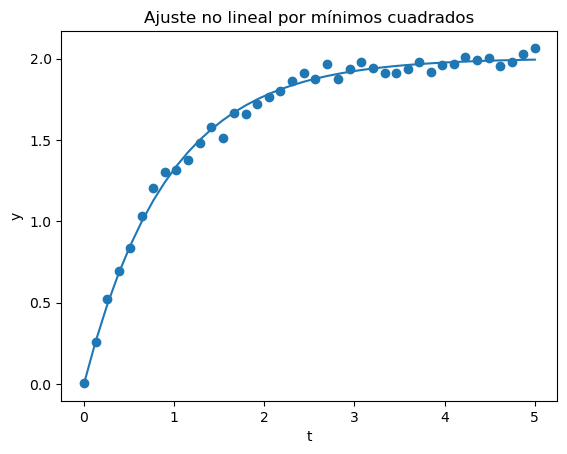

In [6]:

# Datos sintéticos con ruido
rng = np.random.default_rng(0)
t = np.linspace(0, 5, 40)
a_true, b_true = 2.0, 1.1
y_obs = a_true*(1 - np.exp(-b_true*t)) + rng.normal(0, 0.05, size=t.shape)

def ls_objective(theta):
    a, b = theta
    y_hat = a*(1 - np.exp(-b*t))
    resid = y_obs - y_hat
    return np.dot(resid, resid)  # suma de cuadrados

def ls_grad(theta):
    a, b = theta
    ebt = np.exp(-b*t)
    y_hat = a*(1 - ebt)
    resid = y_obs - y_hat
    # derivadas
    d_da = -2*np.sum(resid*(1 - ebt))
    d_db = -2*np.sum(resid*(a * t * ebt))
    return np.array([d_da, d_db])

theta0 = np.array([1.0, 0.5])
res = minimize(ls_objective, theta0, jac=ls_grad, method="L-BFGS-B", bounds=[(0,None),(0,None)])
print("Convergencia:", res.message, "  theta*:", res.x.round(4))

# Visualización
plt.figure()
plt.scatter(t, y_obs)
plt.plot(t, res.x[0]*(1 - np.exp(-res.x[1]*t)))
plt.title("Ajuste no lineal por mínimos cuadrados")
plt.xlabel("t"); plt.ylabel("y")
plt.show()



<a id="9"></a>
## 9. Ejemplo D — No convexo en 2D y trayectorias de descenso

Usamos **Rosenbrock**:
\[
f(x,y) = (1 - x)^2 + 100(y - x^2)^2.
\]

- Ilustra sensibilidad a la **inicialización** y a la **elección del método**.
- Contrastamos gradiente simple vs. `trust-constr`.


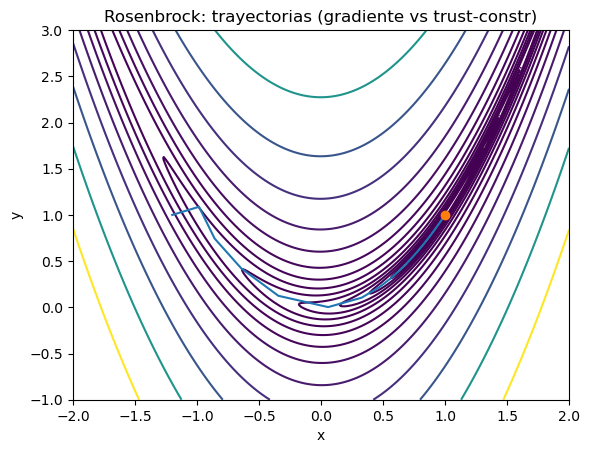

GD final: [1. 1.]  f: 1.250239445490367e-10
trust-constr final: [1. 1.]  f: 5.202826642093156e-20


In [7]:

def rosenbrock(v: np.ndarray) -> float:
    x, y = v
    return (1 - x)**2 + 100*(y - x**2)**2

def grad_rosenbrock(v: np.ndarray) -> np.ndarray:
    x, y = v
    dfdx = -2*(1 - x) - 400*x*(y - x**2)
    dfdy = 200*(y - x**2)
    return np.array([dfdx, dfdy])

# Gradiente con paso fijo (para visualización)
def gradient_descent(f, g, x0, step=1e-3, iters=20000, tol=1e-8, record=200):
    x = x0.copy().astype(float)
    path = [x.copy()]
    for k in range(iters):
        grad = g(x)
        x_new = x - step*grad
        if np.linalg.norm(x_new - x) < tol:
            x = x_new
            path.append(x.copy())
            break
        x = x_new
        if k % record == 0:
            path.append(x.copy())
    return x, path

x0 = np.array([-1.2, 1.0])
x_gd, path_gd = gradient_descent(rosenbrock, grad_rosenbrock, x0, step=1e-3, iters=50000, record=200)

res_trust = minimize(rosenbrock, x0, jac=grad_rosenbrock, method="trust-constr")
x_trust = res_trust.x

# Contornos y trayectorias
xx, yy = np.meshgrid(np.linspace(-2,2,400), np.linspace(-1,3,400))
zz = (1-xx)**2 + 100*(yy - xx**2)**2

plt.figure()
plt.contour(xx, yy, zz, levels=np.logspace(-1,3,15))
pg = np.array(path_gd)
plt.plot(pg[:,0], pg[:,1])
plt.plot(x_trust[0], x_trust[1], marker="o")
plt.title("Rosenbrock: trayectorias (gradiente vs trust-constr)")
plt.xlabel("x"); plt.ylabel("y")
plt.show()

print("GD final:", x_gd.round(4), " f:", rosenbrock(x_gd))
print("trust-constr final:", x_trust.round(4), " f:", rosenbrock(x_trust))



<a id="10"></a>
## 10. Checklist de modelado y elección de métodos

1. **Caracteriza tu problema**: ¿convexo? ¿suave? ¿con caja/simplex/igualdades?  
2. **Elige formulación clara**: objetivo y restricciones, con unidades/interpretación.
3. **Gradientes**: deriva \( \nabla f \) y, si es posible, Hessiano; si no, usa aproximaciones.
4. **Método**:
   - Sin restricciones/caja: L-BFGS-B o trust-region.
   - Simplex: gradiente proyectado, SLSQP, trust-constr.
   - Igualdades/inequidades generales: SLSQP o trust-constr (SQP/punto interior en solvers especializados).
5. **Inicialización**: en no convexos prueba múltiples \(x^0\).
6. **Diagnóstico**: KKT, residuales, sensibilidad a parámetros (\(\lambda\), bounds).
7. **Reporta**: solución, valor de objetivo, chequeos de factibilidad y sensibilidad.

## 11. Referencias y recursos
- Nocedal & Wright, *Numerical Optimization*.  
- Boyd & Vandenberghe, *Convex Optimization*.  
- `scipy.optimize.minimize` (L-BFGS-B, SLSQP, trust-constr).
